In [39]:
#import tensorflow and check if GPU is avilable for training
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#pandas and numpy
import pandas as pd
import numpy as np

#os, glob and zipfile for system processes
import os
import glob
from zipfile import ZipFile

#matplotlib and seaborn to plot images
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#tqdm to show progressbar during processing
from tqdm import tqdm

#cv2 for loading images and resizing them
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,classification_report

#set notebook display options
pd.options.display.max_rows = 500
pd.options.display.max_columns =500

## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

### Load Dataset Files

In [41]:
#mount drive to load datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
#check contents in path to project
!ls -l '/content/drive/My Drive/AIML/Computer Vision with CNN-Project-2_R8'

total 766183
-rw------- 1 root root    273954 Apr 26 09:38 CV_Project2_Dog_Breed_Classification_Questions.ipynb
-rw------- 1 root root    478683 Apr 13 11:21 Keras_ImgAug_Computer_Vision_with_CNN_R7_Project1_Plant_Seedlings_Classification.ipynb
-rw------- 1 root root    218954 Apr 17 17:42 labels.csv.zip
-rw------- 1 root root    401721 Apr 24 10:19 Rsnet_CV_Project2_Dog_Breed_Classification_Questions.ipynb
-rw------- 1 root root    288160 Apr 17 17:42 sample_submission.csv.zip
-rw------- 1 root root 362738853 Apr 17 17:38 test.zip
-rw------- 1 root root 361279070 Apr 17 17:28 train.zip
-rw------- 1 root root  58889256 Apr 22 14:58 vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
#project path in google drive
project_path = "/content/drive/My Drive/AIML/Computer Vision with CNN-Project-2_R8/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
#Extract train set images
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
#Extract test set images
from zipfile import ZipFile
with ZipFile(project_path+'test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
#Extract submission file
from zipfile import ZipFile
with ZipFile(project_path+'sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
#Extract train labels
from zipfile import ZipFile
with ZipFile(project_path+'labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
#Read labels.csv file
labels = pd.read_csv('labels.csv', encoding = "ISO-8859-1")

In [49]:
#shape dtypes and columns in labels df
print(labels.shape)
print(labels.dtypes)
print(labels.columns)

(10222, 2)
id       object
breed    object
dtype: object
Index(['id', 'breed'], dtype='object')


In [50]:
#look into labels df
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Print the count of each category of Dogs given in the dataset



In [51]:
#Count of each category of dog breed in labels
print(labels.breed.value_counts())

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
pomeranian                        111
great_pyrenees                    111
basenji                           110
samoyed                           109
tibetan_terrier                   107
airedale                          107
cairn                             106
leonberg                          106
beagle                            105
japanese_spaniel                  105
miniature_pinscher                102
australian_terrier                102
blenheim_spaniel                  102
irish_wolfhound                   101
saluki                             99
lakeland_terrier                   99
papillon                           96
siberian_husky                     95
norwegian_elkhound                 95
whippet                            95
pug         

In [52]:
print("Number of Classes or categories of Dog breed : ",len(labels.breed.value_counts()))
print("Class names or name of each category of Dog breed : ",labels.breed.value_counts().index)

Number of Classes or categories of Dog breed :  120
Class names or name of each category of Dog breed :  Index(['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher',
       'bernese_mountain_dog', 'shih-tzu', 'pomeranian', 'great_pyrenees',
       'basenji', 'samoyed',
       ...
       'tibetan_mastiff', 'giant_schnauzer', 'walker_hound', 'german_shepherd',
       'otterhound', 'golden_retriever', 'komondor', 'brabancon_griffon',
       'briard', 'eskimo_dog'],
      dtype='object', length=120)


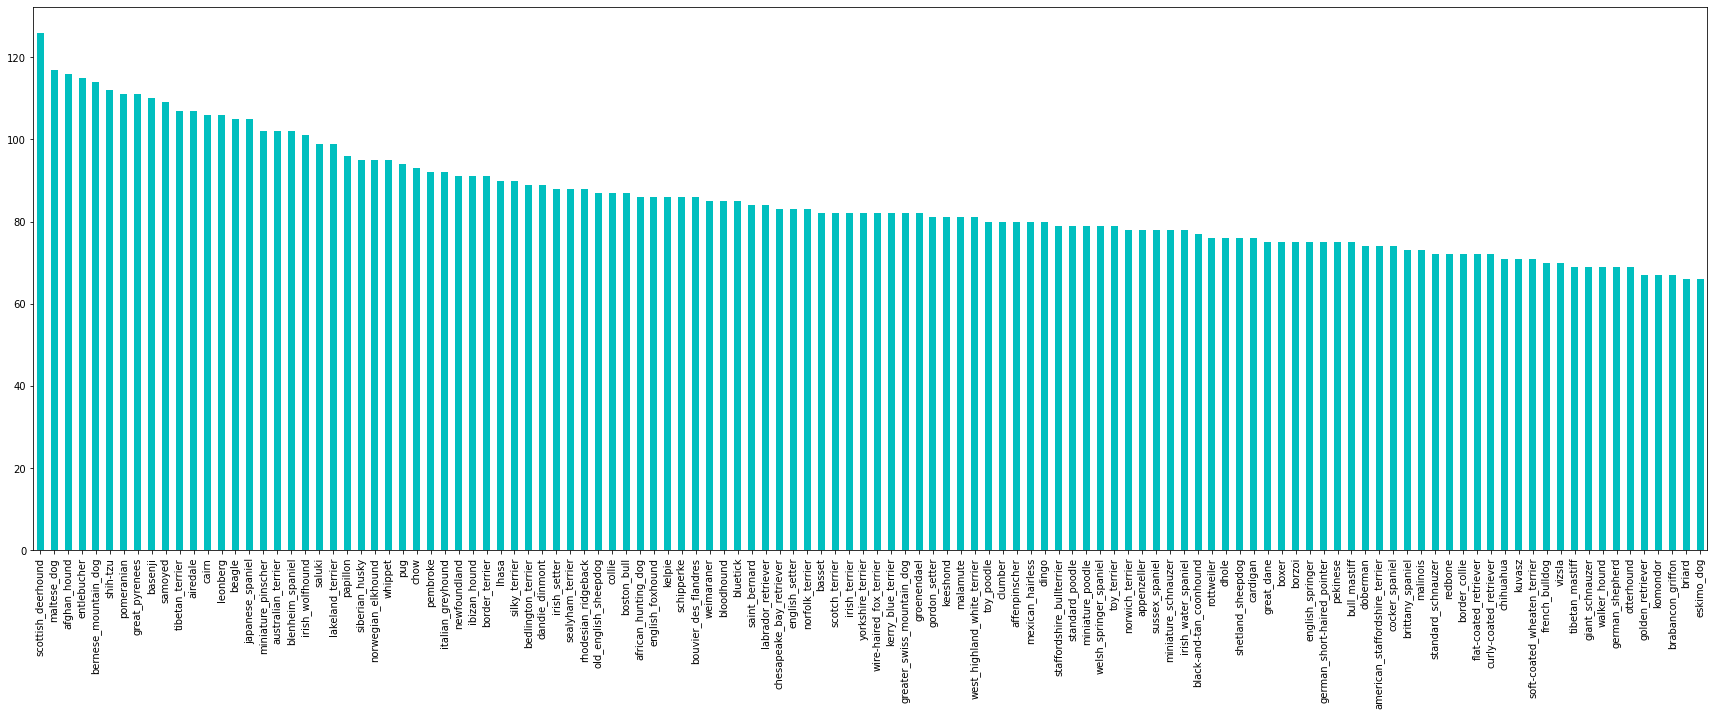

In [53]:
#plot showing counts of each class or category of Dog breed
labels['breed'].value_counts().plot(kind='bar', figsize=(30,10), color='c')
plt.show()

### Get one-hot encodings of labels

In [0]:
#convert class names to one-hot encoded labels using get_dummies and convert the target column to np array
targets = pd.Series(labels['breed'])
one_hot_labels = pd.get_dummies(targets, sparse=True)
one_hot_labels = np.asarray(one_hot_labels)

In [55]:
#check first two rows of target classes
one_hot_labels[0:2]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [0]:
#initialize the no of rows, columns and channels 
img_rows = 128
img_cols = 128
num_channels = 3

In [57]:
#check the label values in label df
print(labels.values)

[['000bec180eb18c7604dcecc8fe0dba07' 'boston_bull']
 ['001513dfcb2ffafc82cccf4d8bbaba97' 'dingo']
 ['001cdf01b096e06d78e9e5112d419397' 'pekinese']
 ...
 ['ffe2ca6c940cddfee68fa3cc6c63213f' 'airedale']
 ['ffe5f6d8e2bff356e9482a80a6e29aac' 'miniature_pinscher']
 ['fff43b07992508bc822f33d8ffd902ae' 'chesapeake_bay_retriever']]


In [58]:
#read train images into x_train after resizing and class names int y_train.use tqdm to show progressbar.
x_train = []
y_train = []

for f, img in tqdm(labels.values): # f for format ,jpg
    train_img = cv2.imread('./train/{}.jpg'.format(f), 1,)
    train_img_resize = cv2.resize(train_img, (img_rows, img_cols)) 
    x_train.append(train_img_resize)
    y_train.append(img)

100%|██████████| 10222/10222 [00:29<00:00, 345.12it/s]


In [59]:
#check any class name in y_train
y_train[12]

'maltese_dog'

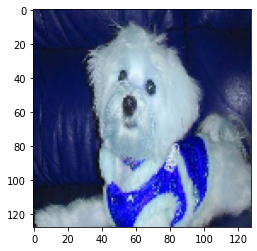

In [60]:
#plot any image from x_train
ax = plt.imshow(x_train[12])

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
#Convert x_train_data to np array with 4 dimensions
x_train_data = np.asarray(x_train).astype('float32')

In [0]:
#Normalize x_train_data
x_train_data = x_train_data/255

In [0]:
#convert class names in y_train to one-hot encoded labels using get_dummies and then convert to np array
y_train_data = np.asarray(pd.get_dummies(y_train, sparse=True))

In [64]:
#Check x_train randomly to understand the shape
x_train_data[0,0:2,0:2,]

array([[[0.27058825, 0.45490196, 0.6784314 ],
        [0.14901961, 0.35686275, 0.53333336]],

       [[0.16470589, 0.3019608 , 0.4627451 ],
        [0.5568628 , 0.7058824 , 0.84705883]]], dtype=float32)

In [65]:
#check y_train randomly to check the one-hot encoded values
y_train_data[0:2]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [66]:
#check the shapes of x_train_data and y_train_data before spliting the data
print("Shapes of x_train_data and y_train_data :\n",x_train_data.shape, y_train_data.shape)

Shapes of x_train_data and y_train_data :
 (10222, 128, 128, 3) (10222, 120)


### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
#split the training data into train_x, test_x, train_y and test_y
train_x, test_x, train_y, test_y = train_test_split(x_train_data, y_train_data, test_size=0.2, random_state=123)

In [68]:
print("Shapes of train_x, train_y, test_x and test_y :\n",train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Shapes of train_x, train_y, test_x and test_y :
 (8177, 128, 128, 3) (8177, 120) (2045, 128, 128, 3) (2045, 120)


### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
#read the submission file into a df
submission = pd.read_csv('sample_submission.csv',encoding = "ISO-8859-1")

#read id column to test_img.id col has the ids of test images for which we need to predict classes
test_img = submission['id']

In [70]:
#shape of test_img is the total no of images for which we need to predict the classes
print("Shape of test_img : ",test_img.shape)

Shape of test_img :  (10357,)


In [71]:
#look into ids in  test_img 
test_img.head()

0    000621fb3cbb32d8935728e48679680e
1    00102ee9d8eb90812350685311fe5890
2    0012a730dfa437f5f3613fb75efcd4ce
3    001510bc8570bbeee98c8d80c8a95ec1
4    001a5f3114548acdefa3d4da05474c2e
Name: id, dtype: object

Run the below code to load the test image files in x_test_feature

In [72]:
#read test images into x_test_feature after resizing.use tqdm to show progressbar.
x_test_feature = []
i = 0 # initialisation
for f in tqdm(test_img.values): # f for format ,jpg
    img = cv2.imread('./test/{}.jpg'.format(f), 1)
    img_resize = cv2.resize(img, (img_rows, img_cols)) 
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:29<00:00, 352.93it/s]


Normalize the test data and convert it into 4 dimensions

In [0]:
#Convert x_test_feature to np array with 4 dimensions
x_test_data = np.asarray(x_test_feature).astype('float32')

In [0]:
#Normalize x_test_feature
x_test_data = x_test_data/255

In [75]:
#Check x_test randomly to understand the shape
x_test_data[0,0:2,0:2,]

array([[[0.2627451 , 0.43529412, 0.40784314],
        [0.30588236, 0.38431373, 0.4117647 ]],

       [[0.1254902 , 0.36078432, 0.3372549 ],
        [0.1254902 , 0.29411766, 0.30588236]]], dtype=float32)

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
#Clear any previous models in session before building the model
tf.keras.backend.clear_session()

#Initialize the model
model1 = tf.keras.models.Sequential()

#Add Conv layer 1 with 64 filters each of kernel_size 5
model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', activation='relu', input_shape=(img_rows,img_cols,3,)))

#Add Batch Normalization layer
model1.add(tf.keras.layers.BatchNormalization())

#Add Dropout layer
model1.add(tf.keras.layers.Dropout(0.30))

#Add Conv layer 2 with 64 filters each of kernel_size 3
model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'))

#Add Batch Normalization layer
model1.add(tf.keras.layers.BatchNormalization())

#Add layer to flatten the output
model1.add(tf.keras.layers.Flatten())

#Add Dense layer with 256 Neurons with activation as relu
model1.add(tf.keras.layers.Dense(256, kernel_initializer = 'he_normal', activation='relu'))

#Add Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classification
model1.add(tf.keras.layers.Dense(120, activation='softmax'))

In [0]:
#Specify optimizer and Loss function and Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [121]:
#Model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 122, 122, 64)      256       
_________________________________________________________________
flatten (Flatten)            (None, 952576)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

In [0]:
#Function to compare the metrics - loss and accuracy for training validation stes over a no of epochs
def plot_metrics(history, ax, fontsize, col1, col2, x_label, y_label, title):
    ax.plot((history.history[col1]))
    ax.plot((history.history[col2]))
    #ax.locator_params(nbins=3)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(['Training-data', 'Test-data'])
    ax.set_title(title)

### Use batch_size = 128 and epochs = 10 and execute the model

In [123]:
#Fit the model with batch-size 128 and run for 10 epochs
history_model1 = model1.fit(train_x, train_y,
                            validation_data=(test_x, test_y),
                            batch_size=128, epochs=10 )

Epoch 1/10
64/64 [==============================] - 54s 836ms/step - loss: 41.2049 - accuracy: 0.0150 - val_loss: 12.2610 - val_accuracy: 0.0078
Epoch 2/10
64/64 [==============================] - 53s 828ms/step - loss: 4.5944 - accuracy: 0.2168 - val_loss: 13.2923 - val_accuracy: 0.0088
Epoch 3/10
64/64 [==============================] - 53s 828ms/step - loss: 3.0878 - accuracy: 0.3461 - val_loss: 26.1049 - val_accuracy: 0.0098
Epoch 4/10
64/64 [==============================] - 53s 827ms/step - loss: 2.6080 - accuracy: 0.4332 - val_loss: 42.0324 - val_accuracy: 0.0117
Epoch 5/10
64/64 [==============================] - 53s 828ms/step - loss: 2.2529 - accuracy: 0.4974 - val_loss: 61.5110 - val_accuracy: 0.0059
Epoch 6/10
64/64 [==============================] - 53s 827ms/step - loss: 2.0151 - accuracy: 0.5498 - val_loss: 42.5958 - val_accuracy: 0.0068
Epoch 7/10
64/64 [==============================] - 53s 827ms/step - loss: 1.8226 - accuracy: 0.5952 - val_loss: 47.0402 - val_accuracy

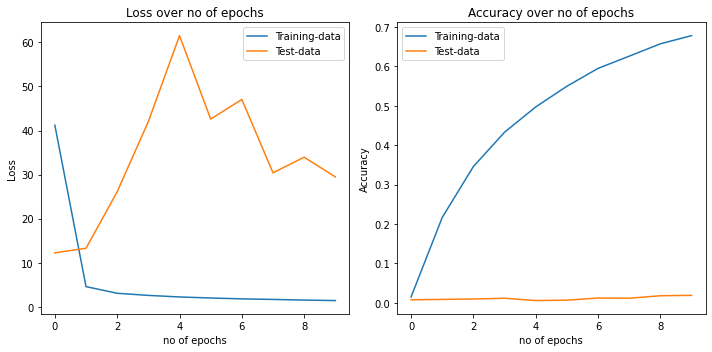

In [124]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_model1, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_model1, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

##### Without any Data Augmentation, the model is overfit and the validation accuracy is very less. We will use Data Augmentaion to improve the accuracy

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
#Create Object of ImageDataGenerator class for generating images with DataAugmentation
#DataAugmentation is done for cetering and standard normalizing each feature in the images and applying transformations
datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                          featurewise_std_normalization=True,
                                                          rotation_range=20,
                                                          width_shift_range=0.20,
                                                          height_shift_range=0.20,
                                                          horizontal_flip=True)

In [0]:
#fit the datagen on train_x
datagen.fit(train_x)

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_generator = datagen.flow(train_x, train_y, batch_size=128)

In [0]:
val_generator = datagen.flow(test_x, test_y, batch_size=128)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

##### We will see a warning message because fit_generator is depricated and we can use the fit method which now supports generators also.
##### Using fit_generator as per above insruction

In [129]:
#Fit the model using fit_generator with batch_size 128 and run for 10 epochs
history_model2 = model1.fit_generator(train_generator,
                                      steps_per_epoch = train_generator.n//128,
                                      validation_data=val_generator,
                                      validation_steps=val_generator.n//128,
                                      epochs=10)

Epoch 1/10
63/63 [==============================] - 57s 903ms/step - loss: 6.9036 - accuracy: 0.0139 - val_loss: 5.6408 - val_accuracy: 0.0115
Epoch 2/10
63/63 [==============================] - 56s 894ms/step - loss: 4.7903 - accuracy: 0.0116 - val_loss: 4.8193 - val_accuracy: 0.0115
Epoch 3/10
63/63 [==============================] - 56s 893ms/step - loss: 4.7852 - accuracy: 0.0103 - val_loss: 4.8111 - val_accuracy: 0.0115
Epoch 4/10
63/63 [==============================] - 56s 887ms/step - loss: 4.7809 - accuracy: 0.0123 - val_loss: 4.7961 - val_accuracy: 0.0115
Epoch 5/10
63/63 [==============================] - 56s 886ms/step - loss: 4.7826 - accuracy: 0.0112 - val_loss: 4.8008 - val_accuracy: 0.0115
Epoch 6/10
63/63 [==============================] - 56s 886ms/step - loss: 4.7828 - accuracy: 0.0111 - val_loss: 4.7971 - val_accuracy: 0.0094
Epoch 7/10
63/63 [==============================] - 56s 887ms/step - loss: 4.7784 - accuracy: 0.0119 - val_loss: 4.8009 - val_accuracy: 0.0104

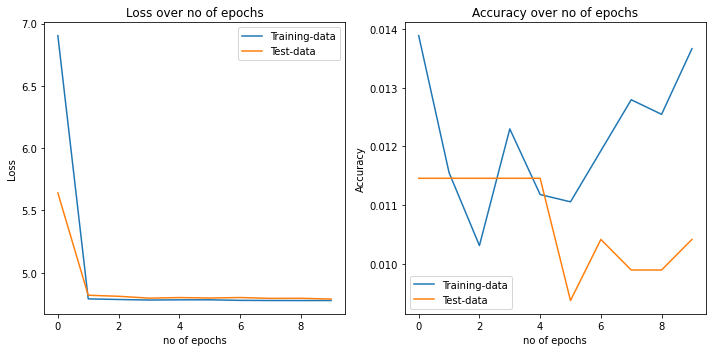

In [130]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_model2, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_model2, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

##### Though the model is not overfit, the training and validation accuracies are very very less.

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
#from keras.applications.vgg16 import VGG16, preprocess_input
#create a  base_model using the weight file for vgg16 which is downloaded from above link

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=(project_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg')

Print the summary of the base_model

In [89]:
#Model summary with base_model
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
#Clear any previous models in session before building the model
tf.keras.backend.clear_session()

#Initialize the model
model_vgg = tf.keras.models.Sequential()

#Add the VGG16 basemodel to the new model model_vgg
model_vgg.add(base_model)

#Add Batch Normalization layer
model_vgg.add(tf.keras.layers.BatchNormalization())

#Add Dropout layer
model_vgg.add(tf.keras.layers.Dropout(0.30, name='dropout_1'))

#Add layer to flatten the output
model_vgg.add(tf.keras.layers.Flatten())

#Add Dense layer with 1024 Neurons with activation as relu
model_vgg.add(tf.keras.layers.Dense(1024, kernel_initializer = 'he_normal', activation='relu'))

#Add Batch Normalization layer
model_vgg.add(tf.keras.layers.BatchNormalization())

#Add Dropout layer
model_vgg.add(tf.keras.layers.Dropout(0.30, name='dropout_2'))

#Add Dense layer with 256 Neurons with activation as relu
model_vgg.add(tf.keras.layers.Dense(256, kernel_initializer = 'he_normal', activation='relu'))

#Add Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classification
model_vgg.add(tf.keras.layers.Dense(120, activation='softmax'))

In [91]:
#Model summary for the new model model_vgg which has the weights from vgg16 base_model included
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
#Make all layers in base_model as Non-trainable
for layer in base_model.layers:
  layer.trainable = False

In [93]:
#Model summary after making all base_model layers as Non-trainable
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

In [0]:
#Specify optimizer and Loss function and Compile the model
optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
model_vgg.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
#Using callbacks add a checkpont to check the max accuracy and save the best model
model_vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='dog_breed_classification_best.h5',
                                                          monitor='val_accuracy',
                                                          save_best_only=True,
                                                          mode='max',
                                                          verbose=1)

In [96]:
#Fit the model using fit method with batch_size 128 and run for 10 epochs.fit method now supports generators also
history_model_vgg = model_vgg.fit(train_generator,
                                  steps_per_epoch=train_generator.n//128,
                                  validation_data=val_generator,
                                  validation_steps=val_generator.n//128,
                                  epochs=10,
                                  callbacks=[model_vgg_checkpoint])

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 4.2431 - accuracy: 0.1454
Epoch 00001: val_accuracy improved from -inf to 0.18854, saving model to dog_breed_classification_best.h5
63/63 [==============================] - 43s 686ms/step - loss: 4.2431 - accuracy: 0.1454 - val_loss: 3.6101 - val_accuracy: 0.1885
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 3.1094 - accuracy: 0.2562
Epoch 00002: val_accuracy improved from 0.18854 to 0.23906, saving model to dog_breed_classification_best.h5
63/63 [==============================] - 39s 624ms/step - loss: 3.1094 - accuracy: 0.2562 - val_loss: 3.2824 - val_accuracy: 0.2391
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 2.7487 - accuracy: 0.3198
Epoch 00003: val_accuracy improved from 0.23906 to 0.27552, saving model to dog_breed_classification_best.h5
63/63 [==============================] - 39s 620ms/step - loss: 2.7487 - accuracy: 0.3198 - val_loss: 2.9391 - val_accuracy: 0.275

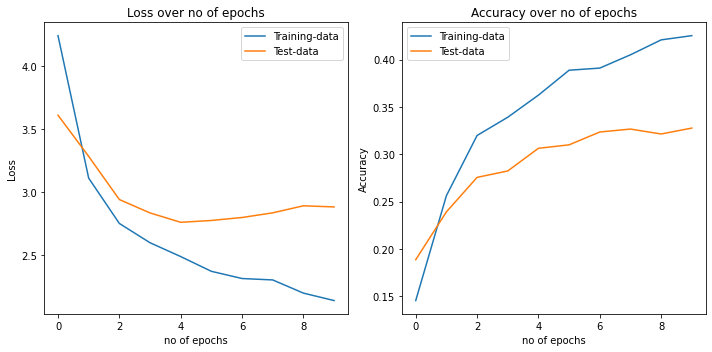

In [97]:
#Plot showing metrics comparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_model_vgg, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_model_vgg, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

In [98]:
#ncrease the number of epochs to 50 and see
history_model_vgg = model_vgg.fit(train_generator,
                                  steps_per_epoch=train_generator.n//128,
                                  validation_data=val_generator,
                                  validation_steps=val_generator.n//128, 
                                  initial_epoch=10,
                                  epochs=40,
                                  callbacks=[model_vgg_checkpoint])

Epoch 11/40
63/63 [==============================] - ETA: 0s - loss: 2.0236 - accuracy: 0.4507
Epoch 00011: val_accuracy did not improve from 0.32760
63/63 [==============================] - 40s 628ms/step - loss: 2.0236 - accuracy: 0.4507 - val_loss: 3.0516 - val_accuracy: 0.3063
Epoch 12/40
63/63 [==============================] - ETA: 0s - loss: 2.0321 - accuracy: 0.4484
Epoch 00012: val_accuracy did not improve from 0.32760
63/63 [==============================] - 40s 630ms/step - loss: 2.0321 - accuracy: 0.4484 - val_loss: 2.9935 - val_accuracy: 0.3177
Epoch 13/40
63/63 [==============================] - ETA: 0s - loss: 1.9739 - accuracy: 0.4644
Epoch 00013: val_accuracy did not improve from 0.32760
63/63 [==============================] - 40s 637ms/step - loss: 1.9739 - accuracy: 0.4644 - val_loss: 2.8794 - val_accuracy: 0.3271
Epoch 14/40
63/63 [==============================] - ETA: 0s - loss: 1.8836 - accuracy: 0.4876
Epoch 00014: val_accuracy did not improve from 0.32760
63/6

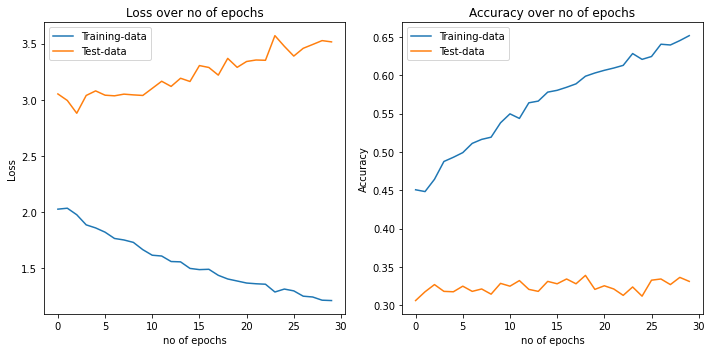

In [99]:
#Plot showing metrics comparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_model_vgg, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_model_vgg, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

#### By freezing all layers of VGG16 base model and making them Non-Trainable, we have obtained Training accuracy of 65% and Validation accuracy of 34%

# Model accuracy is VERY LOW !!!

##### Using transfer learning concept We have used the pre-trained vgg16 model to improve the accuracy.
##### Though the model performance is better over previous models, the accuracy is still very low.
##### We will try to improve the accuracy by including the last conv layer in the base model for vgg

Try to get training and validation accuracy to be more than 90%

In [100]:
#Make all layers in base_model as Non-trainable
for layer in base_model.layers:
  #if (layer.name =='block5_conv2' or layer.name =='block5_conv3' or layer.name =='block5_pool' or layer.name =='global_average_pooling2d'):
  if (layer.name =='block5_conv3'):
    print(layer.name,"is Trainable")
    layer.trainable = True
  else:
    print(layer.name,"is Non-Trainable")
    layer.trainable = False


input_1 is Non-Trainable
block1_conv1 is Non-Trainable
block1_conv2 is Non-Trainable
block1_pool is Non-Trainable
block2_conv1 is Non-Trainable
block2_conv2 is Non-Trainable
block2_pool is Non-Trainable
block3_conv1 is Non-Trainable
block3_conv2 is Non-Trainable
block3_conv3 is Non-Trainable
block3_pool is Non-Trainable
block4_conv1 is Non-Trainable
block4_conv2 is Non-Trainable
block4_conv3 is Non-Trainable
block4_pool is Non-Trainable
block5_conv1 is Non-Trainable
block5_conv2 is Non-Trainable
block5_conv3 is Trainable
block5_pool is Non-Trainable
global_average_pooling2d is Non-Trainable


In [101]:
#Model summary after making last 2 Conv layers in base_model trainable
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [0]:
#Specify optimizer and Loss function and Compile the model
#Specify optimizer and Loss function and Compile the model
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model_vgg.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [103]:
#Fit the model using fit method with batch_size 128 and run for 50 epochs.fit method now supports generators also
history_model_vgg2 = model_vgg.fit(train_generator,
                                  steps_per_epoch=train_generator.n//128,
                                  validation_data=val_generator,
                                  validation_steps=val_generator.n//128,
                                  epochs=50,
                                  callbacks=[model_vgg_checkpoint])

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 1.8532 - accuracy: 0.5013
Epoch 00001: val_accuracy did not improve from 0.33906
63/63 [==============================] - 39s 623ms/step - loss: 1.8532 - accuracy: 0.5013 - val_loss: 4.5067 - val_accuracy: 0.2109
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 1.4107 - accuracy: 0.5963
Epoch 00002: val_accuracy did not improve from 0.33906
63/63 [==============================] - 39s 620ms/step - loss: 1.4107 - accuracy: 0.5963 - val_loss: 3.8322 - val_accuracy: 0.2891
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 1.2127 - accuracy: 0.6427
Epoch 00003: val_accuracy did not improve from 0.33906
63/63 [==============================] - 39s 620ms/step - loss: 1.2127 - accuracy: 0.6427 - val_loss: 3.5623 - val_accuracy: 0.3198
Epoch 4/50
63/63 [==============================] - ETA: 0s - loss: 1.0921 - accuracy: 0.6734
Epoch 00004: val_accuracy did not improve from 0.33906
63/63 [=

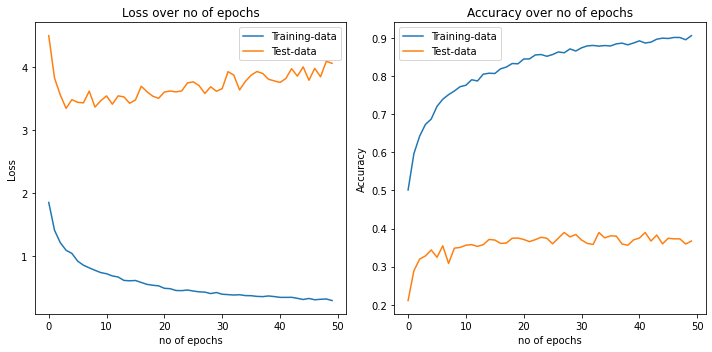

In [104]:
#Plot showing metrics comparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_model_vgg2, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_model_vgg2, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

##### After unfreezing, the last conv layer (block5_conv3) of VGG16 base model, we are getting Training accuracy of 91% and Validation accuracy of 40%.The model performance is better.

## Summary
### After 50 epochs the Training accuracy has improved to __91%__ and Validation accuracy has improved to __40%__
### We see that there is big gap between plots for training and validation in both Loss and Accuracy plots, so the model is overfit and not generalising well.
### We can try to get a better model using any other pre-trained models like Resnet models or Inception models